In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
from matplotlib import pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from models import SciNet
import pandas as pd
from utils import target_loss, data_gen
import loader
import seaborn as sns
import json
from pysr import PySRRegressor
import torch.optim.lr_scheduler as lr_scheduler
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import json
import os
from models import SciNet
import loader
import torch.optim.lr_scheduler as lr_scheduler
from utils import target_loss, data_gen

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Function to train SciNet model for a given beta value
def train_scinet(beta, dataloader, model, optimizer, scheduler, N_EPOCHS):
    hist_error = []
    hist_kl = []
    hist_loss = []

    for epoch in range(N_EPOCHS):  
        epoch_error = []
        epoch_kl = []
        epoch_loss = []

        for i_batch, minibatch in enumerate(dataloader):
            time_series, _, question, answer = minibatch['timeserie'] / 5, minibatch['vars'] / 5, minibatch['question'] / 5, minibatch['answer'] / 5

            inputs = torch.cat((time_series, question.reshape(-1, 1)), 1).to(device)
            outputs = answer.to(device)

            optimizer.zero_grad()
            pred = model.forward(inputs)
            
            loss_ = target_loss(pred, outputs)
            kl = beta * model.kl_loss
            loss = loss_ + kl
            loss.backward()
            optimizer.step()

            error = torch.mean(torch.sqrt((pred[:, 0] - outputs) ** 2)).cpu().detach().numpy()
            epoch_error.append(error)
            epoch_kl.append(kl.data.cpu().detach().numpy())
            epoch_loss.append(loss_.data.cpu().detach().numpy())

        hist_error.append(np.mean(epoch_error))
        hist_loss.append(np.mean(epoch_loss))
        hist_kl.append(np.mean(epoch_kl))

        before_lr = optimizer.param_groups[0]["lr"]
        scheduler.step()
        after_lr = optimizer.param_groups[0]["lr"]
        print("Epoch %d: SGD lr %.6f -> %.6f" % (epoch + 1, before_lr, after_lr))
        print("Epoch %d -- loss %f, RMS error %f, KL %f" % (epoch + 1, hist_loss[-1], hist_error[-1], hist_kl[-1]))

    return hist_loss, hist_error, hist_kl

# Constants and data generation
t_size = 25
size = 35
t_max = 5
n_formula = 0
t = np.linspace(0, t_max, t_size)
with open("equations.json", 'r') as json_file:
    formulas = json.load(json_file)
np.random.seed(523)
data = data_gen(formulas, n_formula, size, t_max, t)

# DataLoader setup
dataset = loader.SciNet_loader(data=data)
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

# Setup SciNet model with 3 latent neurons
scinet = SciNet(t_size, 1, 3, 100).to(device)

# Training setup
N_EPOCHS = 50
SAVE_PATH = f"saved_models/scinet1-{t_size}epoch{N_EPOCHS}.dat"
optimizer = optim.Adam(scinet.parameters(), lr=0.001)
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.005, total_iters=N_EPOCHS)

# Test different beta values
beta_values = [-0.2, 0.2, 0.4, 0.6, 0.8]

for beta in beta_values:
    # Clone the initial model for each beta value
    model = SciNet(t_size, 1, 3, 100).to(device)
    model.load_state_dict(torch.load(SAVE_PATH))  # Load the initial model state
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # Reinitialize optimizer
    scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.005, total_iters=N_EPOCHS)  # Reinitialize scheduler

    hist_loss, hist_error, hist_kl = train_scinet(beta, dataloader, model, optimizer, scheduler, N_EPOCHS)

    # Save figures with loss and metrics as titles
    plt.figure()
    plt.plot(hist_loss, label='Total Loss')
    plt.plot(hist_error, label='RMS Error')
    plt.plot(hist_kl, label='KL Divergence')
    plt.xlabel('Epochs')
    plt.legend()
    plt.title(f'Training History - Beta {beta}\nLoss: {hist_loss[-1]:.4f}, RMS Error: {hist_error[-1]:.4f}, KL: {hist_kl[-1]:.4f}')
    plt.savefig(f'beta/training_history_beta{beta}.png')
    plt.close()
    timeseries = np.array([i["timeserie"] for i in data])
    vars = np.array([i["vars"] for i in data])
    timeseries = torch.tensor(timeseries, dtype=torch.float32).to(device)
    scinet_latent = scinet.encoder(timeseries / 5).cpu().detach().numpy()
    scinet_latent

    # %%
    # Create a correlation matrix
    correlation_matrix = np.corrcoef(vars, scinet_latent, rowvar=False)[3:, :3]

    # Plot the correlation matrix using seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", xticklabels=[f"var {i}" for i in range(correlation_matrix.shape[1])], yticklabels=[f"SciNet_latent {i}" for i in range(correlation_matrix.shape[1])])
    plt.title(f'Correlation Matrix between vars and scinet_latent, beta{beta}')
    plt.show()

In [2]:
t_size = 25
size = 35
t_max = 5
n_formula = 0
t = np.linspace(0, t_max, t_size)
with open("equations.json", 'r') as json_file:
    formulas = json.load(json_file)
np.random.seed(523)
data = data_gen(formulas, n_formula, size, t_max, t)

In [3]:
dataset = loader.SciNet_loader(data=data)
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)
# Setup scinet model with 3 latent neurons
scinet = SciNet(t_size,1,3,100).to(device)

# Training setup
N_EPOCHS = 200
SAVE_PATH = f"saved_models/scinet1-{t_size}epoch{N_EPOCHS}.dat"
optimizer = optim.Adam(scinet.parameters(), lr=0.001)
hist_error = []
hist_kl = []
hist_loss = []
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.005, total_iters=N_EPOCHS)
beta = 0.5
# Training loop
for epoch in range(N_EPOCHS):  
    epoch_error = []
    epoch_kl = []
    epoch_loss = []
    for i_batch, minibatch in enumerate(dataloader):
        time_series, _, question, answer = minibatch['timeserie'] / 5, minibatch['vars'] / 5, minibatch['question'] / 5, minibatch['answer'] / 5

        # concat the time series with the features
        inputs = torch.cat((time_series, question.reshape(-1, 1)), 1).to(device)
        # build the output
        outputs = answer.to(device)
        optimizer.zero_grad()
        pred = scinet.forward(inputs)
        # print(pred)
        # break
        loss_ = target_loss(pred, outputs)
        kl = beta * scinet.kl_loss
        loss = loss_ + kl
        loss.backward()
        optimizer.step()
        error = torch.mean(torch.sqrt((pred[:,0]-outputs)**2)).cpu().detach().numpy()
        epoch_error.append(error)
        epoch_kl.append(kl.data.cpu().detach().numpy())
        epoch_loss.append(loss_.data.cpu().detach().numpy())
    hist_error.append(np.mean(epoch_error))
    hist_loss.append(np.mean(epoch_loss))
    hist_kl.append(np.mean(epoch_kl))

    before_lr = optimizer.param_groups[0]["lr"]
    scheduler.step()
    after_lr = optimizer.param_groups[0]["lr"]
    print("Epoch %d: SGD lr %.6f -> %.6f" % (epoch+1, before_lr, after_lr))
    
    print("Epoch %d -- loss %f, RMS error %f, KL %f" % (epoch+1, hist_loss[-1], hist_error[-1], hist_kl[-1]))
torch.save(scinet.state_dict(), SAVE_PATH)
print("Model saved to %s" % SAVE_PATH)

Epoch 1: SGD lr 0.001000 -> 0.000995
Epoch 1 -- loss 531.352478, RMS error 0.557343, KL 17207.718750
Epoch 2: SGD lr 0.000995 -> 0.000990
Epoch 2 -- loss 387.459686, RMS error 0.499293, KL 124.955910
Epoch 3: SGD lr 0.000990 -> 0.000985
Epoch 3 -- loss 468.458435, RMS error 0.529962, KL 259.245056
Epoch 4: SGD lr 0.000985 -> 0.000980
Epoch 4 -- loss 588.573059, RMS error 0.598209, KL 6.283029
Epoch 5: SGD lr 0.000980 -> 0.000975
Epoch 5 -- loss 550.290039, RMS error 0.658087, KL 6.033542
Epoch 6: SGD lr 0.000975 -> 0.000970
Epoch 6 -- loss 637.343262, RMS error 0.684769, KL 11.618922
Epoch 7: SGD lr 0.000970 -> 0.000965
Epoch 7 -- loss 540.748535, RMS error 0.654780, KL 5.817200
Epoch 8: SGD lr 0.000965 -> 0.000960
Epoch 8 -- loss 549.309265, RMS error 0.711072, KL 5.843979
Epoch 9: SGD lr 0.000960 -> 0.000955
Epoch 9 -- loss 483.743591, RMS error 0.715056, KL 6.865662
Epoch 10: SGD lr 0.000955 -> 0.000950
Epoch 10 -- loss 480.927307, RMS error 0.730673, KL 8.990450
Epoch 11: SGD lr 0.

C:\Users\amine\AppData\Local\Temp\ipykernel_23296\3016749620.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


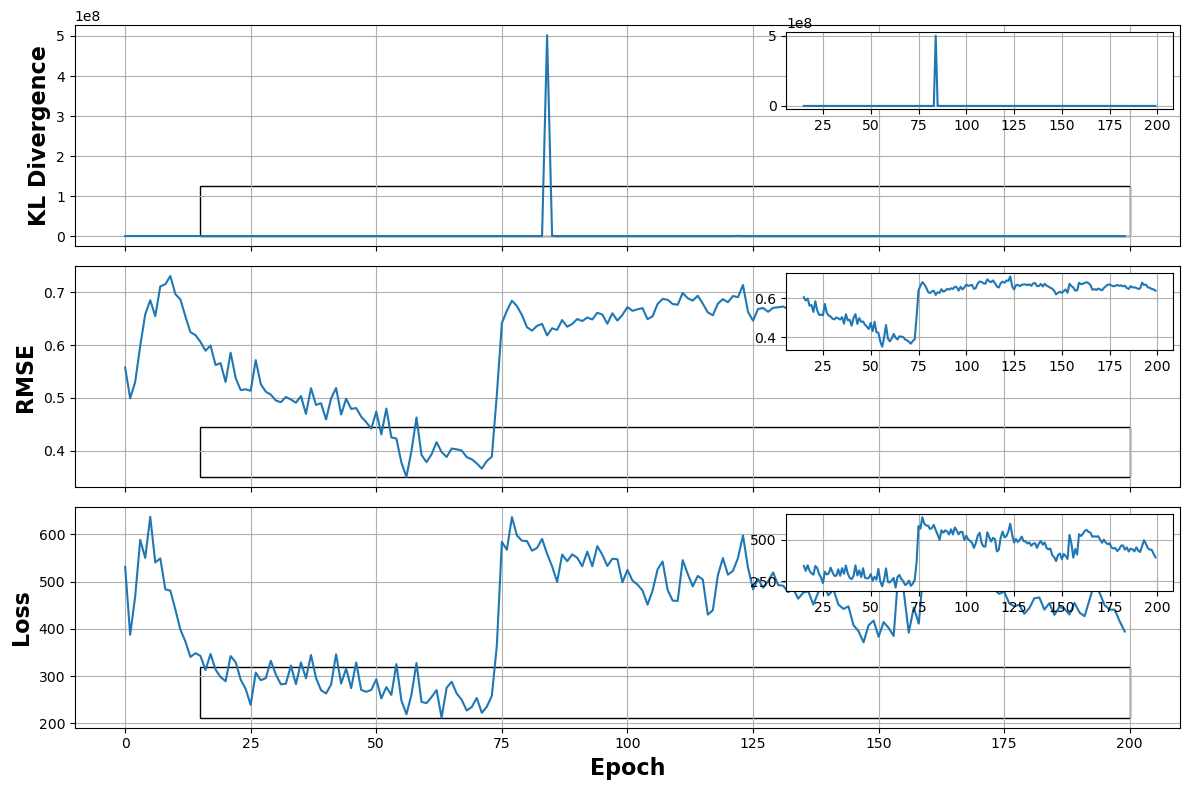

In [4]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Create a figure with three subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# Define the starting epoch for zooming in
start_epoch = 15  # Change this to your desired starting epoch
end_epoch = N_EPOCHS  # Change this to your desired ending epoch
epochs = list(range(N_EPOCHS))
# Plot the first subplot
axs[0].plot(epochs, hist_kl)
axs[0].set_ylabel("KL Divergence", fontsize=16, fontweight='bold')
axs[0].grid(True)

# Create an inset_axes for zooming in on the first subplotss
axins1 = inset_axes(axs[0], width="35%", height="35%", loc='upper right')
axins1.plot(epochs[start_epoch:end_epoch], hist_kl[start_epoch:end_epoch])
axins1.grid(True)

# Add a thinner, black rectangle with smaller height to the initial plot indicating the zoomed-in area
rect1 = Rectangle((start_epoch, min(hist_kl)), end_epoch - start_epoch, (max(hist_kl) - min(hist_kl)) / 4, fill=False, edgecolor='black', linewidth=1)
axs[0].add_patch(rect1)

# Plot the second subplot
axs[1].plot(epochs, hist_error)
axs[1].set_ylabel("RMSE", fontsize=16, fontweight='bold')
axs[1].grid(True)

# Create an inset_axes for zooming in on the second subplot
axins2 = inset_axes(axs[1], width="35%", height="35%", loc='upper right')
axins2.plot(epochs[start_epoch:end_epoch], hist_error[start_epoch:end_epoch])
axins2.grid(True)

# Add a thinner, black rectangle with smaller height to the initial plot indicating the zoomed-in area
rect2 = Rectangle((start_epoch, min(hist_error)), end_epoch - start_epoch, (max(hist_error) - min(hist_error)) / 4, fill=False, edgecolor='black', linewidth=1)
axs[1].add_patch(rect2)

# Plot the third subplot
axs[2].plot(epochs, hist_loss)
axs[2].set_xlabel("Epoch", fontsize=16, fontweight='bold')
axs[2].set_ylabel("Loss", fontsize=16, fontweight='bold')
axs[2].grid(True)

# Create an inset_axes for zooming in on the third subplot
axins3 = inset_axes(axs[2], width="35%", height="35%", loc='upper right')
axins3.plot(epochs[start_epoch:end_epoch], hist_loss[start_epoch:end_epoch])
axins3.grid(True)

# Add a thinner, black rectangle with smaller height to the initial plot indicating the zoomed-in area
rect3 = Rectangle((start_epoch, min(hist_loss)), end_epoch - start_epoch, (max(hist_loss) - min(hist_loss)) / 4, fill=False, edgecolor='black', linewidth=1)
axs[2].add_patch(rect3)

# Adjust layout
plt.tight_layout()

# Show the plot (optional)
plt.show()


## Symbolic Formulation

### Analysis

In [5]:
model_path = 'saved_models/scinet1-25epoch200.dat'
model = SciNet(t_size,1,3,100).to(device)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [6]:
epoch_error = []
for i_batch, minibatch in enumerate(dataloader):
        time_series, _, question, answer = minibatch['timeserie'] / 5, minibatch['vars'] / 5, minibatch['question'] / 5, minibatch['answer'] / 5

        # concat the time series with the features
        inputs = torch.cat((time_series, question.reshape(-1, 1)), 1).to(device)
        # build the output
        outputs = answer.to(device)
        optimizer.zero_grad()
        pred = model.forward(inputs)
        error = torch.mean(torch.sqrt((pred[:,0]-outputs)**2)).cpu().detach().numpy()
        epoch_error.append(error)
sum(epoch_error) / len(epoch_error)


0.6416750860103082

In [7]:
timeseries = np.array([i["timeserie"] for i in data])
vars = np.array([i["vars"] for i in data])
timeseries = torch.tensor(timeseries, dtype=torch.float32).to(device)
scinet_latent = model.encoder(timeseries / 5).cpu().detach().numpy()
scinet_latent

array([[ -726.25555  , -1349.5616   ,   100.25403  ],
       [  101.70511  ,   659.9849   ,    13.378945 ],
       [    2.9932964,     7.684849 ,    -3.4308887],
       ...,
       [ -102.03617  ,   298.47745  ,  -222.9934   ],
       [  139.25291  ,  -137.87334  ,   -30.755297 ],
       [ -178.41638  ,  -273.19208  ,    66.671814 ]], dtype=float32)

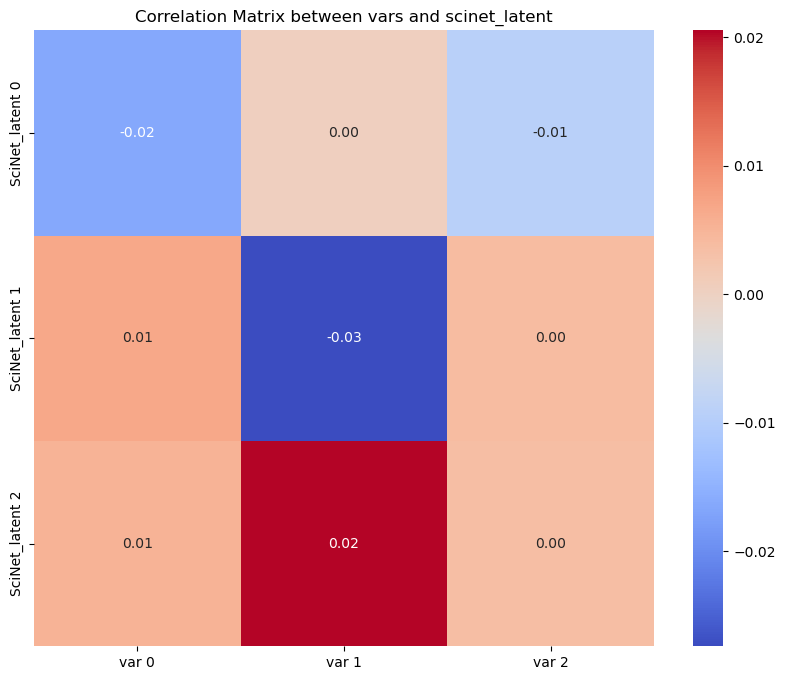

In [8]:
# Create a correlation matrix
correlation_matrix = np.corrcoef(vars, scinet_latent, rowvar=False)[3:, :3]

# Plot the correlation matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", xticklabels=[f"var {i}" for i in range(correlation_matrix.shape[1])], yticklabels=[f"SciNet_latent {i}" for i in range(correlation_matrix.shape[1])])
plt.title('Correlation Matrix between vars and scinet_latent')
plt.show()

### PySR part

In [9]:
question = np.array([[i["question"]] for i in data])
answer = np.array([i["answer"] for i in data])
x = np.concatenate([scinet_latent, question], axis=1)
y = answer

In [10]:
model = PySRRegressor(
    niterations=70,  # < Increase me for better results
    binary_operators=["+", "*"],
    unary_operators=[
        "cos",
        "exp",
        "sin",
        "log",
        "inv(x) = 1/x",
        # ^ Custom operator (julia syntax)
    ],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    # ^ Define operator for SymPy as well
    loss="loss(prediction, target) = (prediction - target)^2",
    # ^ Custom loss function (julia syntax)
)

In [11]:
#model.fit(x,y)

c:\Users\amine\miniconda3\envs\net\Lib\site-packages\pysr\sr.py:1281: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
c:\Users\amine\miniconda3\envs\net\Lib\site-packages\pysr\sr.py:1850: UserWarning: Note: you are running with more than 10,000 datapoints. You should consider turning on batching (https://astroautomata.com/PySR/options/#batching). You should also reconsider if you need that many datapoints. Unless you have a large amount of noise (in which case you should smooth your dataset first), generally < 10,000 datapoints is enough to find a functional form with symbolic regression. More datapoints will lower the search speed.
  warnings.warn(
c:\Users\amine\miniconda3\envs\net\Lib\site-packages\pysr\julia_helpers.py:171: UserWarning: `torch` was loaded before the Julia instance started. This may cause a segfault when running `PySRRegressor.fit`. To avoid this, please run `pysr.julia_helpers.init_julia()` *before*

Compiling Julia backend...


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                         0.43742692   
	1         0.001559                                       cos(inv(x0))   
	2         0.003959                        cos(inv(-0.034686774 * x2))   
	3         0.000006                   cos(inv(sin(-0.034686774) * x2))   
	4         0.002637                 ((cos(inv(x0)) + -0.6144061) * x3)   
	5   >>>>  0.064416                exp(sin(cos(-1.5720739) * x1) * x3)   
	6         0.004498  exp(exp(sin(-1.8248246 + (cos(-1.5720739) * x1...   
	7         0.006931  exp(exp(sin(-1.7342951 + (cos(-1.5720739) * (x...   
	8         0.048293  exp(exp(sin(-1.8219588 + (sin(cos(-1.5720739) ...   
	9         0.035652  exp(exp(sin(-1.7342951 + (sin(sin(cos(-1.57207...   
	10        0.021258  exp(exp(sin(-1.5329741 + (sin((cos(-1.5720739)...   
	11        0.025499  exp(exp(sin(-1.5329741 + (sin(sin((cos(-1.5720...   
	12        0.010845  exp(exp(sin(-1.7342951 + (sin(sin((cos(-1.5720...   
	13        0.008702  (exp(exp(sin(-1.7342951 + (sin(sin((cos(-1.572...   
	14        0.013236  (exp(exp(sin(-1.7342951 + (sin(sin((cos(-1.572...   
	
	         loss  complexity  
	0   225.96109           1  
	1   225.25752           3  
	2   223.48082           5  
	3   223.47955           6  
	4   222.89110           7  
	5   208.98610           8  
	6   206.18521          11  
	7   203.34676          13  
	8   193.75989          14  
	9   186.97360          15  
	10  183.04082          16  
	11  178.43245          17  
	12  176.50783          18  
	13  174.97860          19  
	14  172.67784          20  
]